# Set up Environment

In [52]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import copy
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [53]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 7.2.0
anndata             0.7.4
annoy               NA
attr                20.1.0
backcall            0.2.0
bbknn               NA
cffi                1.14.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
idna                2.10
igraph              0.8.2
importlib_metadata  1.7.0
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.2
jinja2              2.11.2
joblib              0.16.0
jsonschema          3.2.0
kiwisolver          1.2.0
legacy_api_wrap     1.2
leidenalg           0.8.1
llvmlite            0.34.0
louvain             0.7.0
markupsafe          1.1.1
matplotlib          3.3.1
mpl_toolkits        NA
natsort             7.0.1
nbformat            5.0.7
numba               0.51.0
numexpr             2.7.1
numpy       

In [54]:
combined = sc.read('/scratch/qc_filtered_combined_samples.h5ad')

# Select the Cells of Interest

#### Before any further analysis we will exclude the cells that are neither CD8+ nor TCR+. First select the TCR and CD8 genes. #### Even though drop-out events are possible, it is extremely unlikely if drop-outs happen simultaneous for all 160 genes of a single cell. So by doing this we are almost 100% confident that we are subsetting all the T-cells, especially all of the CD8 T-cells

In [55]:
selected_genes = combined.var_names.str.startswith(("TRAV","TRAJ","TRBV","TRBD","TRBJ","CD8A","CD8B"))
CD8_related_genes = set(combined[:,selected_genes].var_names)

In [56]:
print("There are {} genes selected".format(len(CD8_related_genes)))

There are 160 genes selected


In [57]:
kept_cells = combined[:,'CD8A'].X>0
for gene in set(CD8_related_genes):
    kept_cells = kept_cells + (combined[:,gene].X>0)

In [58]:
# Now abusing the notation ( we again call it "combined" so that we don't have to change the rest of the code), we subset 
# the cells using the genes 
combined = combined[kept_cells,:]

# Select Important and Highly Variable Genes

#### Find highly variable features/genes that will also provide a good separation of the cell types and cell clusters.

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Trying to set attribute `.uns` of view, copying.


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
Highly variable genes: 200


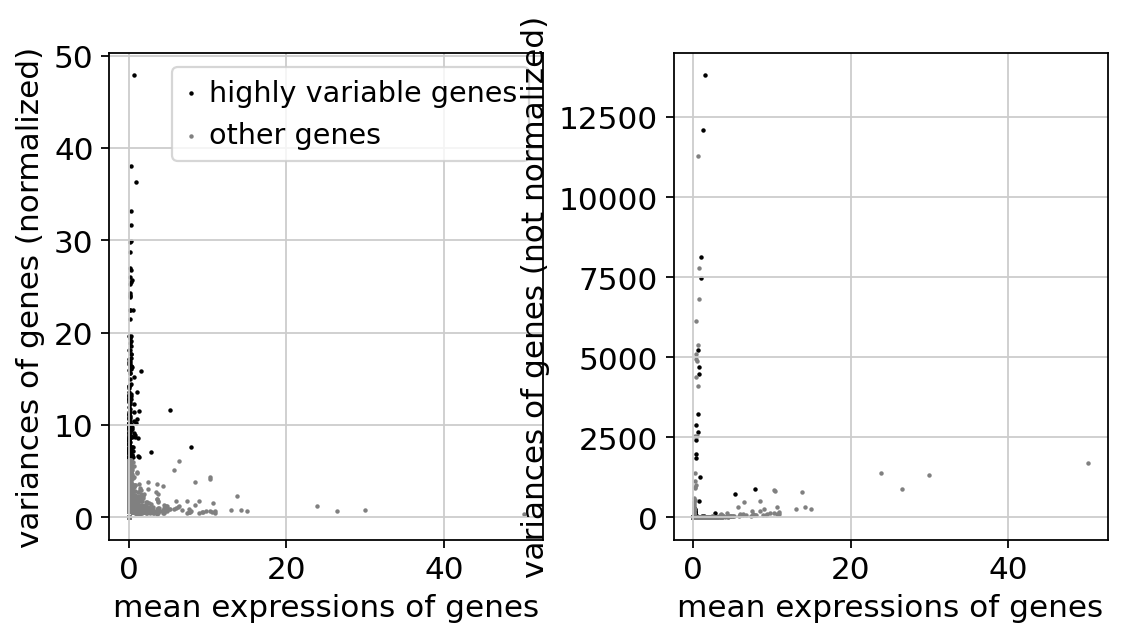

In [59]:
# compute variable genes
sc.pp.highly_variable_genes(combined, flavor='seurat_v3',n_top_genes=200)
print("Highly variable genes: {}".format(sum(combined.var.highly_variable)))

# plot variable genes
sc.pl.highly_variable_genes(combined)

CD62L,L-selectin: 'SELL', CD45: 'PTPRC'

In [60]:
important_marker_genes = ['CD8A','CD8B','PTPRC','TBX21','CCR5','CXCR3','IL7','SELL','GATA3','CCR6','IL4','GZMB',
                 'PRF1','IL2RB','IL2RA','FOXP3','CD28','IL10','CD44','EOMES','IL17A','IL17B','IL17C','IL10']

CD95:'FAS', CD11a:'ITGAL', CD18:'ITGB2', CD11b:'ITGAM', CD29:'ITGB1', CD49d:'ITGA4'

In [61]:
important_Tmemory_genes = ['CD27','FAS','IFNG','KLRG1','ITGAL','ITGB2','ITGB1','ITGAM','ITGA4','CCR7']

PD-1: 'PDCD1', TIM3:'HAVCR2'

In [62]:
exhaustion_markers = ['CXCL13','CTLA4','PDCD1','HAVCR2','TIGIT','BTLA','CD244','CD160','ICOS']

CD137:'TNFRSF9', KI67:'MKI67'

In [63]:
proliferation_markers = ['TOP2A','MKI67','TNFRSF9'] 

In [64]:
HLA_genes = combined.var_names.str.startswith(('HLA'))
HLA_genes = list(combined[:,HLA_genes].var_names)

In [65]:
important_genes = important_marker_genes + HLA_genes + important_Tmemory_genes+exhaustion_markers+proliferation_markers

In [66]:
# restore the genes in case they are filtered out, all genes (including top 200 and the important markers 
# are stored as highly variable)
for gene in important_genes:
    combined.var['highly_variable'][gene] = True

In [67]:
# combined.raw stores a scopy of the data at current stage
# we do this since we will trim genes and only use the top few hundreds for clustering, yet we want to retain all genes for
# differential expression purposes

In [68]:
combined.raw = combined
combined = combined[:, combined.var['highly_variable']]

## PCA

regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)
... be careful when using `max_value` without `zero_center`.
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:01)


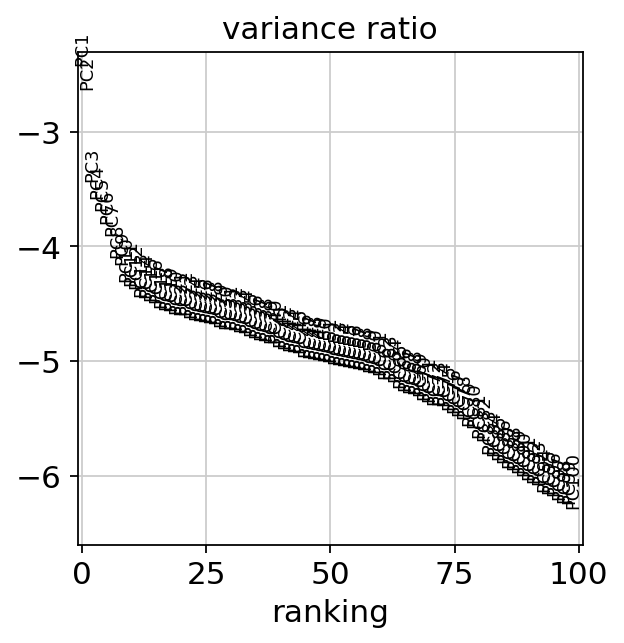

In [69]:
# regress out effects of total counts per cell and scale genes to have unit variance
sc.pp.regress_out(combined, ['total_counts'])
sc.pp.scale(combined, zero_center=False, max_value=10)

sc.tl.pca(combined, svd_solver='arpack',n_comps=100,use_highly_variable=True)
sc.pl.pca_variance_ratio(combined, log=True, n_pcs = 100)

In [70]:
save_file = '/scratch/PCA_decomposed_combined_samples.h5ad'
combined.write_h5ad(save_file)

#### Based on the plot, we choose 50 principal components (around second elbow point) for downstream clustering methods.

# Dimension Reduction by Manifold Embedding

## UMAP without Batch Correction

In [71]:
combined1 = copy.deepcopy(combined)

In [72]:
# compute neighbor graph
sc.pp.neighbors(combined1, n_neighbors=10, n_pcs=80)

computing neighbors
    using 'X_pca' with n_pcs = 80
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)


In [73]:
# compute umap projection
uncorrected_umap = sc.tl.umap(combined1, n_components=2, copy=True,min_dist=0.05)
# Leiden clustering
sc.tl.leiden(uncorrected_umap)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:36)
running Leiden clustering
    finished: found 50 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:12)


In [74]:
# find marker genes
sc.tl.rank_genes_groups(uncorrected_umap, groupby='leiden',method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:27)


In [75]:
# save file 
save_file = '/scratch/uncorrected_umap.h5ad'
uncorrected_umap.write_h5ad(save_file)

## UMAP with Batch Correction

In [76]:
# bbknn is a batch correction algorithm that also computes neighbor graph (two birds with one stone)
sc.external.pp.bbknn(combined, batch_key='bat', n_pcs=80)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [77]:
# project to a 2-dimensional subspace, save to a new object so that the umap with 2D is not overwritten.
batch_corrected_umap = sc.tl.umap(combined, n_components=2, copy=True,min_dist=0.05)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:36)


In [78]:
# Leiden clustering
sc.tl.leiden(batch_corrected_umap)
# find marker genes
sc.tl.rank_genes_groups(batch_corrected_umap, groupby='leiden',method='wilcoxon')

running Leiden clustering
    finished: found 39 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:22)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:22)


In [79]:
# save file 
save_file = '/scratch/batch_corrected_umap.h5ad'
batch_corrected_umap.write_h5ad(save_file)